### 01 packages

In [1]:
##########################################################################################
##########################################################################################

import networkx as nx

from shapely.geometry import Point,Polygon

import math

import random

##########################################################################################
##########################################################################################

import numpy as np

import pandas as pd

##########################################################################################
##########################################################################################

import matplotlib

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

##########################################################################################
##########################################################################################

from itertools import combinations, permutations

from itertools import islice

##########################################################################################
##########################################################################################

import copy

import os


### 02 interior parameters

In [9]:
##########################################################################################
##########################################################################################

length=1e3

##########################################################################################
##########################################################################################

Base_speed=int(10000/60) # 10 KM per hour

##########################################################################################
##########################################################################################

alpha=1

speed=alpha*Base_speed

##########################################################################################
##########################################################################################

batch_interval=1

##########################################################################################
##########################################################################################

fixed_weight=(2*length)/speed

##########################################################################################
##########################################################################################

instance='03'

##########################################################################################
##########################################################################################


# Set the lambda parameter for the Poisson distribution

lambda_value = 5

pattern='uniform'#'centralized','uniform'

##########################################################################################
##########################################################################################

save_path="./03result/03Multi-hop/"+pattern+'_'+str(lambda_value)

if not os.path.exists(save_path):
    
    os.makedirs(save_path)

##########################################################################################
##########################################################################################

Nodes=np.load("./01network/"+instance+"/Nodes.npy")

Edges=np.load("./01network/"+instance+"/Edges.npy")

##########################################################################################
##########################################################################################

Hexagons=np.load("./01network/"+instance+"/Hexagons.npy")

Hexagon_nodes=np.load("./01network/"+instance+"/Hexagon_nodes.npy",allow_pickle=True).item()

# Hexagon_edges=np.load("./01network/"+instance+"/Hexagon_edges.npy",allow_pickle=True).item()

##########################################################################################
##########################################################################################

Hexagon_Vertices=np.load("./01network/"+instance+"/Hexagon_Vertices.npy",allow_pickle=True).item()

# Hexagon_Center=np.load("./01network/"+instance+"/Hexagon_Center.npy",allow_pickle=True).item()

Hexagons_Neighbors=np.load("./01network/"+instance+"/Hexagons_Neighbors.npy",allow_pickle=True).item()

##########################################################################################
##########################################################################################

Road_Graph = nx.Graph()

for node in Nodes:
    
    node=tuple(node)
        
    Road_Graph.add_node(node)

for edge in Edges:
    
    node1=tuple(edge[0])
    
    node2=tuple(edge[1])
    
    Road_Graph.add_edge(node1, node2, weight=Point(node1).distance(Point(node2)))
    
##########################################################################################
##########################################################################################

k=10

### 03 Load  locker network

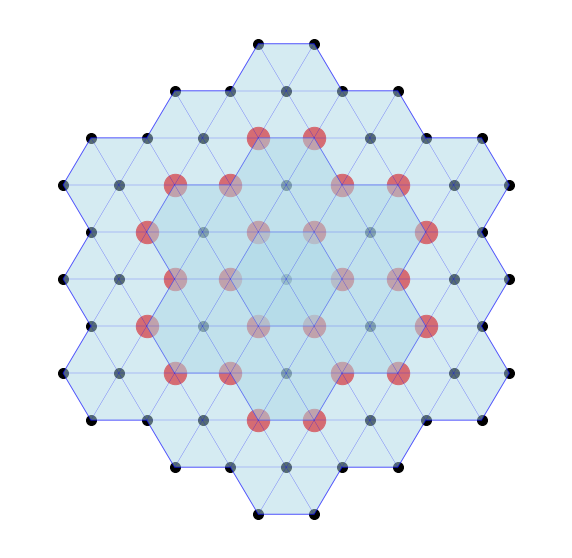

In [10]:
##########################################################################################
##########################################################################################

Lockers=np.load("./01network/"+instance+"/Lockers.npy")

Lockers=tuple([(x[0],x[1]) for x in Lockers])

Locker_Hexagon=np.load("./01network/"+instance+"/Locker_Hexagon.npy",allow_pickle=True).item()

Hexagon_Locker=np.load("./01network/"+instance+"/Hexagon_Locker.npy",allow_pickle=True).item()

##########################################################################################
##########################################################################################

figsize = 10,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 15}

figure, axs = plt.subplots(figsize=figsize)

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]
    
axs.set_xlabel('X',font_label)

axs.set_ylabel('Y',font_label)

axs.set_xlim([-5000,5000])

axs.set_ylim([-5000,5000])

for edge in Road_Graph.edges:
    
    axs.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]], color='blue',linewidth=.2,linestyle='-')

for vertice in Hexagon_Vertices.values():
    
    hexagon = matplotlib.patches.Polygon(vertice, closed=True, edgecolor='blue', facecolor='lightblue',alpha=0.5)
    
    axs.add_patch(hexagon)


for node in Road_Graph.nodes:
    
    if node not in Lockers:
    
        axs.scatter(node[0], node[1], color='black',s=100,alpha=1)
        
    else:
        
        axs.scatter(node[0], node[1], color='red',s=500,alpha=1)

        
    
# Hide the x and y axes

plt.axis('off')

plt.show()



### 04  Region network

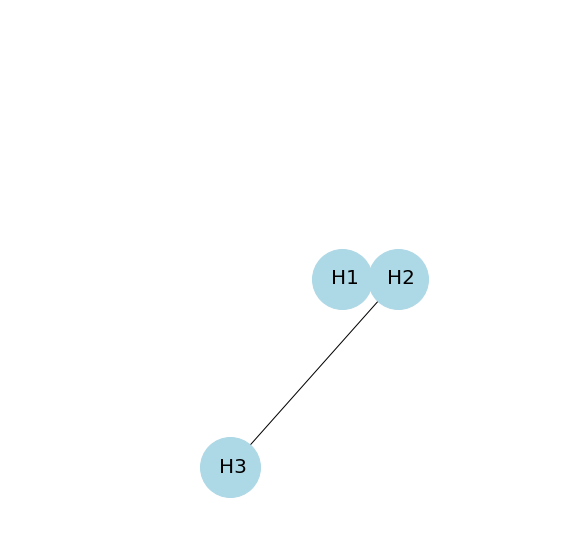

In [11]:
Region_G = nx.Graph()

Region_G.add_nodes_from(Hexagons)

for hexagon_id in Hexagons_Neighbors:
    
    for neighor_id in Hexagons_Neighbors[hexagon_id]:
        
        Region_G.add_edge(hexagon_id, neighor_id)
        
##########################################################################################
##########################################################################################

figsize = 10,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 15}

figure, axs = plt.subplots(figsize=figsize)

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]
    
axs.set_xlabel('X',font_label)

axs.set_ylabel('Y',font_label)

axs.set_xlim([-5000,5000])

axs.set_ylim([-5000,5000])


# Draw the graph

# Draw nodes as red circles

for edge in Region_G.edges:
    
    hexagon_1,hexagon_2=edge[0],edge[1]
    
    axs.plot([Hexagon_Vertices[hexagon_1][0][0],Hexagon_Vertices[hexagon_2][0][0]],[Hexagon_Vertices[hexagon_1][0][1],Hexagon_Vertices[hexagon_2][0][1]], color='black',linewidth=1,linestyle='-')
    
    

for hexagon_id in Region_G.nodes:
    
    center=Hexagon_Vertices[hexagon_id][0]
    
    axs.plot(center[0], center[1], 'o', color='lightblue',alpha=1,markersize=60)
    
    axs.text(center[0]-0.2*length,center[1]-0.1*length, hexagon_id, fontsize=20, color='black')


    
# Display the plot

plt.axis('off')

plt.show()

### 05 Graph-based on-line algorithm

If multiple vehicles exist in the network, our goal assign the shortest path for each vehicle. However, vehicle will add the congestion level in the network, further affect the travel time on the links within the assigned path.

In [100]:
##########################################################################################
##########################################################################################

    
def total_travel_distance(trajectory):
    
    total_distance = 0.0
    
    # Iterate through the trajectory and calculate the distance for each consecutive pair of coordinates
    
    for i in range(len(trajectory) - 1):
        
        total_distance += nx.shortest_path_length(Road_Graph, source=trajectory[i], target=trajectory[i + 1], weight='weight') 
    
    return total_distance


##########################################################################################
##########################################################################################

parcel_df=pd.read_csv('./02data/01/instance_'+str(lambda_value)+'_'+pattern+'.csv')

parcel_df=parcel_df.drop(columns=['Unnamed: 0'])

##########################################################################################
##########################################################################################

parcel_df['pick_up']=parcel_df.apply(lambda x:tuple([round(float(y),2) for y in x.pick_up.replace('(','').replace(')','').split(',')]),axis=1)

parcel_df['drop_off']=parcel_df.apply(lambda x:tuple([round(float(y),2) for y in x.drop_off.replace('(','').replace(')','').split(',')]),axis=1)

##########################################################################################
##########################################################################################

parcel_df['courier_id']='None'

parcel_df['pick_up_time']=-float('inf')

parcel_df['drop_off_time']=-float('inf')

##########################################################################################
##########################################################################################

courier_df=pd.read_csv('./02data/'+instance+'/courier_instance.csv')

courier_df=courier_df.drop(columns=['Unnamed: 0'])

##########################################################################################
##########################################################################################

Hexagon_courier={}

for idx,row in courier_df.iterrows():
    
    if row.hexagon not in Hexagon_courier.keys():
        
        Hexagon_courier[row.hexagon]=[row.courier_id]
        
    else:
        
        Hexagon_courier[row.hexagon].append(row.courier_id)

##########################################################################################
##########################################################################################

courier_schedules={}

for idx,row in courier_df.iterrows():
    
    courier_schedules[row.courier_id]={i:((row.x,row.y),['park']) for i in range(1,batch_interval+1,1)}
    
##########################################################################################
##########################################################################################

parcel_schedules={}

for idx,row in parcel_df.iterrows():
    
    parcel_schedules[row.parcel_id]={}
    
##########################################################################################
##########################################################################################

task_df=pd.DataFrame([],columns=['parcel_id','task_id','pick_up','drop_off','hexagon',\
                                 'courier_id','pick_up_time','drop_off_time'])

##########################################################################################
##########################################################################################

t=copy.copy(batch_interval)

couriers_candidates=list()

##########################################################################################
##########################################################################################


dynamic_completions={}

dynamic_distances={}


while True:

    # collect parcels
    
    collected_parcel=copy.copy(parcel_df.loc[(parcel_df.t_a<=t)&(parcel_df.drop_off_time<=0)])
    
    ##########################################################################################
    ##########################################################################################
    
    # update the batch time
    
    if collected_parcel.shape[0]==0:
        
        ##########################################################################################
        ##########################################################################################
        
        if t%10==0:
            
            ttdis=0.0

            for schedules in courier_schedules.values():

                trajectory=list([v[0] for k,v in schedules.items() if k<=t])

                ttdis+=total_travel_distance(trajectory)

            print("*"*100)

            print("Minute is ",t,", Number of completions is ",parcel_df.loc[(parcel_df.drop_off_time>=0)&(t>parcel_df.drop_off_time)].shape[0],\
                  ", Total travel distance(KM) is ",round(ttdis/1000.0,2))
            
            dynamic_completions[t]=parcel_df.loc[(parcel_df.drop_off_time>=0)&(t>parcel_df.drop_off_time)].shape[0]
            
            dynamic_distances[t]=round(ttdis/1000.0,2)

        t=int(t+batch_interval)
        
        ##########################################################################################
        ##########################################################################################

        
        for courier_id,schedules in courier_schedules.items():
            
            courier_realse_time=list(schedules.keys())[-1]
            
            courier_realse_point=tuple(list(schedules.values())[-1][0])
            
            if courier_realse_time<t:
                
                for t_step in range(courier_realse_time+1,t+1,1):
                    
                     courier_schedules[courier_id][t_step]=(courier_realse_point,['park'])

        
    else:
        
        ##########################################################################################
        ##########################################################################################
        
        # select parcel with the earliest due time

        collected_parcel=collected_parcel.sort_values(by='t_dl', ascending=True)
        
        idx=collected_parcel.index.to_list()[0]
        
        select_parcel=collected_parcel.loc[idx]
        
        ##########################################################################################
        ##########################################################################################
    
        # 01 get the current time

        parcel_id=select_parcel.parcel_id
        
        t_a=select_parcel.t_a
        
        pick_up_point=select_parcel.pick_up
        
        drop_off_point=select_parcel.drop_off
        
        pick_up_hexagon=select_parcel.h1
        
        drop_off_hexagon=select_parcel.h2

        ##########################################################################################
        ##########################################################################################

        # 02 calculate the ealiest release time for each hexagon

        weights={}

        for hexagon_id in Hexagons:

            weights[hexagon_id]=0.0

            for courier_id in Hexagon_courier[hexagon_id]:

                release_time=max(list(courier_schedules[courier_id].keys()))

                weights[hexagon_id]=min(release_time-t,weights[hexagon_id])

        for hexagon_id, weight in weights.items():

            Region_G.nodes[hexagon_id]["weight"] = weights[hexagon_id]+fixed_weight# weights[hexagon_id]#+fixed_weight
            
        # Create a new graph with edge weights equal to the node weights
        
        Weighted_Region_G = nx.Graph()
        
        for edge in Region_G.edges():
            
            Weighted_Region_G.add_edge(edge[0], edge[1], weight=Region_G.nodes[edge[0]]['weight'])

        ##########################################################################################
        ##########################################################################################

        # 03 find the region path in the region network

        h1,h2=select_parcel.h1,select_parcel.h2

        shortest_region_path = nx.shortest_path(Weighted_Region_G, source=h1, target=h2,weight="weight")
        
        if len(shortest_region_path)>1:
            
            if pick_up_point in Hexagon_nodes[shortest_region_path[1]]:
            
                shortest_region_path=shortest_region_path[1:]

        ##########################################################################################
        ##########################################################################################

        # 04 find the shortest path in the locker network
        
        shortest_path=[pick_up_point]
        
        if len(shortest_region_path)>1:
            
            for i in range(1,len(shortest_region_path),1):
                
                start_hexagon=shortest_region_path[i-1]
                
                target_hexagon=shortest_region_path[i]
                
                visiting_nodes={}
                
                for node in Hexagon_nodes[target_hexagon]:
                    
                    if node in Hexagon_nodes[start_hexagon]:
                    
                        visiting_nodes[node]=nx.shortest_path_length(Road_Graph, source=node, target=drop_off_point, weight='weight')
                    
                target_node=min(visiting_nodes, key=visiting_nodes.get)
                
                shortest_path.append(target_node)
                
        if drop_off_point not in shortest_path:
            
            shortest_path.append(drop_off_point)
                  
        ##########################################################################################
        ##########################################################################################
        
        # 05 take the first task

        select_hexagon=shortest_region_path[0]
        
        if len(shortest_region_path)>1:
        
            target_hexagon=shortest_region_path[1]
            
        else:
            
            target_hexagon=shortest_region_path[0]
            
        ##########################################################################################
        ##########################################################################################
        
        select_task=[shortest_path[0],shortest_path[1]]
        
        start_point=shortest_path[0]
        
        finish_point=shortest_path[1]
        
        ##########################################################################################
        ##########################################################################################
        
        # 06 check the sechedule
        
        pick_up_times={}
        
        drop_off_times={}
        
        optimal_insertions={}
        
        total_completion_times={}

        for courier_id in Hexagon_courier[select_hexagon]:

            schedule={k:node for k,node in courier_schedules[courier_id].items() if k>=t}
            
            courier_realse_time=list(schedule.keys())[-1]
                
            courier_realse_point=tuple(list(schedule.values())[-1][0])
            
            visiting_nodes=[node[0] for k,node in schedule.items()]
            
            visiting_timeline=[k for k,node in schedule.items()]
        
            total_completion_time=float('inf')
            
            for pickup_insert_idx in range(1,len(visiting_nodes)+1,1):

                pickup_visiting_nodes=copy.copy(visiting_nodes)

                pickup_visiting_nodes.insert(pickup_insert_idx,start_point)

                pick_up_time=copy.copy(visiting_timeline[0])

                for search_idx in range(1,pickup_insert_idx+1,1):

                    pick_up_time+=int(nx.shortest_path_length(Road_Graph, source=pickup_visiting_nodes[search_idx-1], target=pickup_visiting_nodes[search_idx], weight='weight')/speed)

                for drop_insert_idx in range(pickup_insert_idx+1,len(pickup_visiting_nodes)+1,1):

                    dropoff_visiting_nodes=copy.copy(pickup_visiting_nodes)

                    dropoff_visiting_nodes.insert(drop_insert_idx,finish_point)

                    drop_off_time=copy.copy(pick_up_time)

                    for search_idx in range(pickup_insert_idx+1,drop_insert_idx+1,1):

                        drop_off_time+=int(nx.shortest_path_length(Road_Graph, source=dropoff_visiting_nodes[search_idx-1], target=dropoff_visiting_nodes[search_idx], weight='weight')/speed)

                    completion_time=copy.copy(drop_off_time)

                    for search_idx in range(drop_insert_idx+1,len(dropoff_visiting_nodes),1):

                        completion_time+=int(nx.shortest_path_length(Road_Graph, source=dropoff_visiting_nodes[search_idx-1], target=dropoff_visiting_nodes[search_idx], weight='weight')/speed)

                    if completion_time<total_completion_time:

                        optimal_pick_up_time=pick_up_time

                        optimal_drop_off_time=drop_off_time

                        optimal_pick_up_idx=pickup_insert_idx

                        optimal_drop_off_idx=drop_insert_idx

                        total_completion_time=completion_time
            
            total_completion_times[courier_id]=total_completion_time
                            
            drop_off_times[courier_id]=optimal_drop_off_time
            
            pick_up_times[courier_id]=optimal_pick_up_time
            
            optimal_insertions[courier_id]={'pick_up_idx':optimal_pick_up_idx,'drop_off_idx':optimal_drop_off_idx}
            
        ##########################################################################################
        ##########################################################################################

        select_courier_id=min(total_completion_times, key=total_completion_times.get)
        
        ##########################################################################################
        ##########################################################################################
                                           
        # 05 extract the courier schedule
        
        select_schedule={k:node for k,node in courier_schedules[select_courier_id].items() if k>=t}
        
        select_courier_realse_time=list(select_schedule.keys())[-1]
                
        select_courier_realse_point=tuple(list(select_schedule.values())[-1][0])
        
        select_visiting_nodes=[node[0] for k,node in select_schedule.items()]
        
        select_visiting_type=[node[1] for k,node in select_schedule.items()]
            
        select_visiting_timeline=[k for k,node in select_schedule.items()]
        
        kept_schedule=copy.copy({k:node for k,node in courier_schedules[select_courier_id].items() if k<t})
        
        ##########################################################################################
        ##########################################################################################
        
        optimal_pick_up_idx=optimal_insertions[select_courier_id]['pick_up_idx']
        
        optimal_drop_off_idx=optimal_insertions[select_courier_id]['drop_off_idx']
        
        ##########################################################################################
        ##########################################################################################
        
        select_visiting_nodes.insert(optimal_pick_up_idx,start_point)

        select_visiting_type.insert(optimal_pick_up_idx,['pick_up_'+parcel_id])

        select_visiting_nodes.insert(optimal_drop_off_idx,finish_point)

        select_visiting_type.insert(optimal_drop_off_idx,['drop_off_'+parcel_id])
        
        ##########################################################################################
        ##########################################################################################
        
        parcel_schedules[parcel_id][select_courier_id]={}
        
        parcel_schedules[parcel_id][select_courier_id]['pick_up']=(start_point,pick_up_times[select_courier_id])

        parcel_schedules[parcel_id][select_courier_id]['drop_off']=(finish_point,drop_off_times[select_courier_id])
        
        ##########################################################################################
        ##########################################################################################
        
        update_schedule_time=list(select_schedule.keys())[0]
        
        update_schedule_point=tuple(list(select_schedule.values())[0])
        
        update_schedule={update_schedule_time:update_schedule_point}
        
        ##########################################################################################
        ##########################################################################################
    
        for node_idx in range(1,len(select_visiting_nodes),1):
            
            travel_time=int(nx.shortest_path_length(Road_Graph, source=select_visiting_nodes[node_idx-1], target=select_visiting_nodes[node_idx], weight='weight')/speed)
            
            if travel_time==0 and 'park' not in select_visiting_type[node_idx-1] and 'en-route' not in select_visiting_type[node_idx-1] and 'en-route' not in select_visiting_type[node_idx]:

                update_schedule[update_schedule_time]=(select_visiting_nodes[node_idx],select_visiting_type[node_idx-1]+select_visiting_type[node_idx])

            elif travel_time==0 and 'en-route' in select_visiting_type[node_idx]:

                pass

            else:

                update_schedule_time+=travel_time

                update_schedule[update_schedule_time]=(select_visiting_nodes[node_idx],select_visiting_type[node_idx])
                
        ##########################################################################################
        ##########################################################################################
        
        update_schedule_={}
        
        update_trajectory=list(update_schedule.values())
        
        update_stamp=list(update_schedule.keys())
        
        for s_idx in range(1,len(update_trajectory),1):
            
            pre_stamp,pre_loc=update_stamp[s_idx-1],update_trajectory[s_idx-1][0]
            
            cur_stamp,cur_loc=update_stamp[s_idx],update_trajectory[s_idx][0]
            
            update_schedule_[pre_stamp]=update_trajectory[s_idx-1]
            
            intermediate_path=nx.shortest_path(Road_Graph, source=pre_loc, target=cur_loc, weight='weight')
            
            if len(intermediate_path)==2:
                
                update_schedule_[cur_stamp]=update_trajectory[s_idx]
        
            else:
                
                for k in range(1,len(intermediate_path),1):
            
                    distance=nx.shortest_path_length(Road_Graph, source=intermediate_path[k-1], target=intermediate_path[k], weight='weight')

                    travel_time=int(distance/speed)
                    
                    pre_stamp+=travel_time

                    if k==len(intermediate_path)-1:

                        update_schedule_[cur_stamp]=update_trajectory[s_idx]
                        
                    else:
                        
                        update_schedule_[pre_stamp]=(intermediate_path[k],['en-route'])
                        
        ##########################################################################################
        ##########################################################################################
        
        for time_stamp, node_infos in update_schedule_.items():
            
            node_coords=node_infos[0]
            
            for node_info in node_infos[1]:
                
                 if node_info!='park' and node_info!='en-route' and time_stamp>t:
            
                    node_type=node_info.split('_p')[0]

                    update_parcel_id='p'+node_info.split('_p')[1]

                    if node_type=='drop_off':

                        parcel_df.loc[(parcel_df['parcel_id']==update_parcel_id),'t_a']=time_stamp
                        
                        parcel_schedules[update_parcel_id][select_courier_id]['drop_off']=(node_coords,time_stamp)
                        
                        parcel_df.loc[(parcel_df['parcel_id']==update_parcel_id)&(parcel_df['drop_off']==node_coords),'drop_off_time']=time_stamp
                        
                    elif node_type=='pick_up':
                        
                        parcel_schedules[update_parcel_id][select_courier_id]['pick_up']=(node_coords,time_stamp)
                
        ##########################################################################################
        ##########################################################################################
        
        # adjustment 
        
        # (1) extract all the parcels and node types in this schedule
        
        adjust_parcels={}
        
        for time_stamp, node_infos in update_schedule_.items():
            
            node_coords=node_infos[0]
            
            for node_info in node_infos[1]:
                
                 if node_info!='park' and node_info!='en-route' and time_stamp>t:
                        
                        node_type=node_info.split('_p')[0]

                        update_parcel_id='p'+node_info.split('_p')[1]
                        
                        if update_parcel_id not in adjust_parcels.keys():
                            
                            adjust_parcels[update_parcel_id]=[node_type]
                            
                        else:
                            
                            adjust_parcels[update_parcel_id].append(node_type)
                            
        ##########################################################################################

        # (2) update the update_schedule_s based on the item in adujust_parcels
        
        for update_parcel_id, node_types in adjust_parcels.items():
            
            for node_type in node_types:
                
                current_time_node=parcel_schedules[update_parcel_id][select_courier_id][node_type][0]
                
                current_time_stamp=parcel_schedules[update_parcel_id][select_courier_id][node_type][1]
                
                current_event=node_type+'_'+update_parcel_id
                
                for check_time_stamp, check_node_infos in update_schedule_.items():
                    
                    if node_type=='pick_up':
                    
                        if check_time_stamp<current_time_stamp and current_time_node==check_node_infos[0]:
                            
                            update_schedule_[current_time_stamp][1].remove(current_event)
                            
                            update_schedule_[check_time_stamp][1].append(current_event)
                            
                            parcel_schedules[update_parcel_id][select_courier_id]['pick_up']=(current_time_node,check_time_stamp)
                            
                            break
                            
        ##########################################################################################
        
        for update_parcel_id, node_types in adjust_parcels.items():
            
            for node_type in node_types:
                
                current_time_node=parcel_schedules[update_parcel_id][select_courier_id][node_type][0]
                
                current_time_stamp=parcel_schedules[update_parcel_id][select_courier_id][node_type][1]
                
                current_event=node_type+'_'+update_parcel_id
                
                for check_time_stamp, check_node_infos in update_schedule_.items():
                    
                    if node_type=='drop_off':
                        
                        pick_up_time_stamp=parcel_schedules[update_parcel_id][select_courier_id]['pick_up'][1]
                    
                        if pick_up_time_stamp<check_time_stamp and check_time_stamp<current_time_stamp and current_time_node==check_node_infos[0]:
                            
                            update_schedule_[current_time_stamp][1].remove(current_event)
                            
                            update_schedule_[check_time_stamp][1].append(current_event)
                            
                            parcel_schedules[update_parcel_id][select_courier_id]['drop_off']=(current_time_node,check_time_stamp)
                            
                            parcel_df.loc[(parcel_df['parcel_id']==update_parcel_id),'t_a']=check_time_stamp
                            
                            parcel_df.loc[(parcel_df['parcel_id']==update_parcel_id)&(parcel_df['drop_off']==node_coords),'drop_off_time']=check_time_stamp
                            
                            break
                            
        ##########################################################################################
        ##########################################################################################
        
        for check_time_stamp in list(update_schedule_.keys())[::-1]:
            
            check_node_infos=update_schedule_[check_time_stamp][1]
            
            check_node_infos=[node_info.split('_p')[0] for node_info in check_node_infos]
            
            if 'pick_up' not in check_node_infos and 'drop_off' not in check_node_infos:
                
                del update_schedule_[check_time_stamp]
                
            else:
                
                break
                

        ##########################################################################################
        ##########################################################################################
        
        
        kept_schedule.update(update_schedule_)
            
        courier_schedules[select_courier_id]=dict(sorted(kept_schedule.items()))
            
        ##########################################################################################
        ##########################################################################################
        
        parcel_df.loc[(parcel_df['parcel_id']==parcel_id),'courier_id']=select_courier_id
            
        parcel_df.at[idx,'pick_up']=tuple([x for x in finish_point])

        parcel_df.loc[(parcel_df['parcel_id']==parcel_id),'h1']=target_hexagon
        
        
            
        

    ##########################################################################################

    if parcel_df.loc[(parcel_df.drop_off_time<0)].empty and t>parcel_df.drop_off_time.max():
    
        break




****************************************************************************************************
Minute is  10 , Number of completions is  0 , Total travel distance(KM) is  16.0
****************************************************************************************************
Minute is  20 , Number of completions is  0 , Total travel distance(KM) is  62.0
****************************************************************************************************
Minute is  30 , Number of completions is  1 , Total travel distance(KM) is  100.0
****************************************************************************************************
Minute is  40 , Number of completions is  7 , Total travel distance(KM) is  152.0
****************************************************************************************************
Minute is  50 , Number of completions is  13 , Total travel distance(KM) is  202.0
**************************************************************************************

In [97]:
current_event

'drop_off_p133'

In [99]:
current_time_stamp

103

In [98]:
update_schedule_

{43: ((-1500.0, -2598.08),
  ['pick_up_p199',
   'pick_up_p187',
   'pick_up_p188',
   'pick_up_p147',
   'pick_up_p90',
   'drop_off_p37']),
 49: ((-500.0, -2598.08), ['drop_off_p188']),
 55: ((-1500.0, -2598.08), []),
 61: ((-2500.0, -2598.08),
  ['pick_up_p240', 'pick_up_p133', 'pick_up_p125', 'drop_off_p72']),
 67: ((-2000.0, -1732.05),
  ['pick_up_p216',
   'pick_up_p178',
   'pick_up_p130',
   'pick_up_p131',
   'drop_off_p38',
   'drop_off_p5',
   'drop_off_p133']),
 73: ((-1000.0, -1732.05),
  ['drop_off_p240',
   'drop_off_p199',
   'drop_off_p187',
   'drop_off_p178',
   'drop_off_p147',
   'drop_off_p130',
   'drop_off_p90',
   'drop_off_p61',
   'drop_off_p30']),
 79: ((-2000.0, -1732.05), []),
 85: ((-1500.0, -2598.08), ['en-route']),
 91: ((-2000.0, -3464.1), ['drop_off_p216', 'drop_off_p131']),
 97: ((-2500.0, -2598.08), ['drop_off_p119']),
 103: ((-2000.0, -1732.05), ['drop_off_p125'])}

In [ ]:
##########################################################################################
##########################################################################################

# 01 save parcel

parcel_df.to_csv(save_path+"/parcel_df_"+str(alpha)+"_"+str(batch_interval)+".csv")

##########################################################################################
##########################################################################################

def generate_trajectory(origin, destination):
    
    # Calculate the total distance
    
    distance = Point(destination).distance(Point(origin))
    
    # Calculate total time
    total_time = distance / speed
    
    # Calculate the number of intervals
    intervals = int(np.floor(total_time))
    
    # Create an array to hold the trajectory
    trajectory = np.zeros((intervals+1, 2))  # Assuming 2D coordinates
    
    for i in range(intervals+1):
        # Interpolate the position for each time interval
        alpha = i / intervals
        trajectory[i] = np.array(origin) * (1 - alpha) + np.array(destination) * alpha

    return trajectory

##########################################################################################
##########################################################################################

# 02 complete trajectory

trajectory_schedules={}

for courier_id,schedules in courier_schedules.items():
    
    completed_schedules={}
    
    stamps=list(schedules.keys())
    
    nodes=list(schedules.values())
    
    completed_schedules[stamps[0]]=nodes[0][0]
    
    for i in range(1,len(stamps),1):
                                         
        completed_schedules[stamps[i]]=nodes[i][0]
        
        pre_t,t=stamps[i-1],stamps[i]
        
        pre_node,node=nodes[i-1][0],nodes[i][0]
        
        if t>pre_t+1:
            
            trajectory=generate_trajectory(pre_node, node)
            
            for j in range(1,len(trajectory)-1,1):
                
                insert_node=tuple([round(x,2) for x in trajectory[j]])
                
                completed_schedules[int(pre_t+j)]=insert_node
                
    completed_schedules = dict(sorted(completed_schedules.items()))
    
    trajectory_schedules[courier_id]=completed_schedules
            

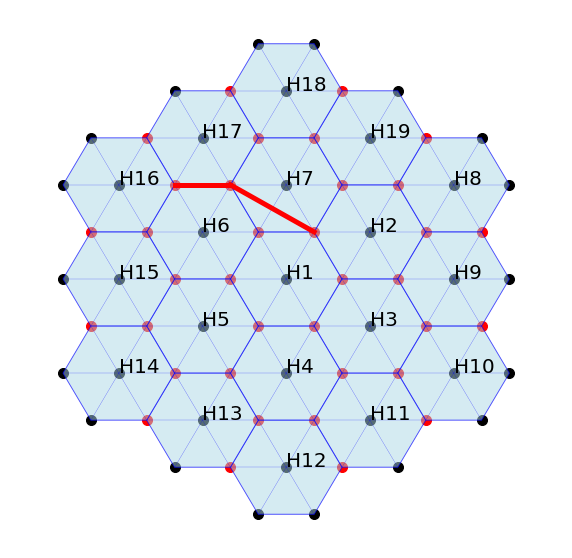

In [23]:
figsize = 10,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 15}

figure, axs = plt.subplots(figsize=figsize)

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]
    
axs.set_xlabel('X',font_label)

axs.set_ylabel('Y',font_label)

axs.set_xlim([-5000,5000])

axs.set_ylim([-5000,5000])

for edge in Road_Graph.edges:
    
    axs.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]], color='blue',linewidth=.2,linestyle='-')

for vertice in Hexagon_Vertices.values():
    
    hexagon = matplotlib.patches.Polygon(vertice, closed=True, edgecolor='blue', facecolor='lightblue',alpha=0.5)
    
    axs.add_patch(hexagon)

    
for hexagon_id, center in Hexagon_Center.items():
    
    axs.text(center[0], center[1], hexagon_id, fontsize=20, color='black')

for node in Road_Graph.nodes:
    
    if node not in Lockers:
    
        axs.scatter(node[0], node[1], color='black',s=100,alpha=1)
        
    else:
        
        axs.scatter(node[0], node[1], color='red',s=100,alpha=1)


path=list([v[0] for k,v in courier_schedules['c21'].items()])

def flatten_list(lst):
    flattened = []
    for item in lst:
        if isinstance(item, list):
            flattened.extend(flatten_list(item))
        else:
            flattened.append(item)
    return flattened

path=flatten_list([[y[0] for y in list(x.values())] for x in parcel_schedules['p11'].values()])

# path=shortest_path

for i in range(1,len(path),1):
    
    axs.plot([path[i-1][0],path[i][0]],[path[i-1][1],path[i][1]], color='red',linewidth=5,linestyle='-',alpha=1)
    


    
# Hide the x and y axes
plt.axis('off')

plt.show()

In [24]:
parcel_schedules['p11']

{'c10': {'pick_up': ((500.0, 866.03), 7),
  'drop_off': ((-1000.0, 1732.05), 25)},
 'c23': {'pick_up': ((-1000.0, 1732.05), 37),
  'drop_off': ((-2000.0, 1732.05), 43)}}

### 06 figure example

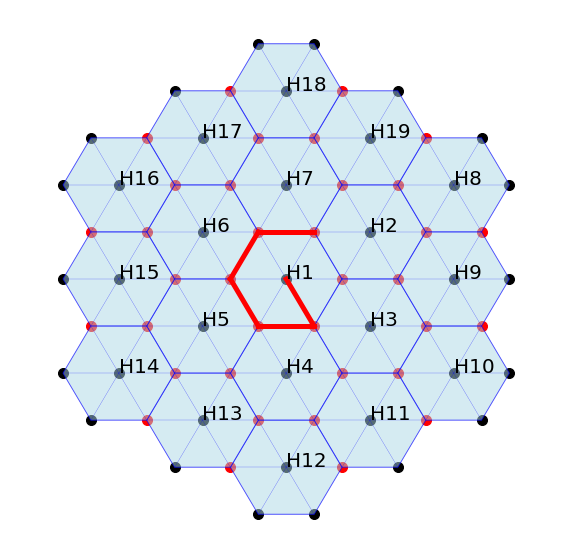

In [25]:
figsize = 10,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 15}

figure, axs = plt.subplots(figsize=figsize)

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]
    
axs.set_xlabel('X',font_label)

axs.set_ylabel('Y',font_label)

axs.set_xlim([-5000,5000])

axs.set_ylim([-5000,5000])

for edge in Road_Graph.edges:
    
    axs.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]], color='blue',linewidth=.2,linestyle='-')

for vertice in Hexagon_Vertices.values():
    
    hexagon = matplotlib.patches.Polygon(vertice, closed=True, edgecolor='blue', facecolor='lightblue',alpha=0.5)
    
    axs.add_patch(hexagon)

    
for hexagon_id, center in Hexagon_Center.items():
    
    axs.text(center[0], center[1], hexagon_id, fontsize=20, color='black')

for node in Road_Graph.nodes:
    
    if node not in Lockers:
    
        axs.scatter(node[0], node[1], color='black',s=100,alpha=1)
        
    else:
        
        axs.scatter(node[0], node[1], color='red',s=100,alpha=1)


path=list([v[0] for k,v in courier_schedules['c1'].items() if k>50])

for i in range(1,len(path),1):
    
    axs.plot([path[i-1][0],path[i][0]],[path[i-1][1],path[i][1]], color='red',linewidth=5,linestyle='-',alpha=1)
    


    
# Hide the x and y axes
plt.axis('off')

plt.show()

In [26]:
import numpy as np
from scipy.spatial import distance_matrix
import random

def calculate_total_dropoff_time(schedule):
    total_time = 0
    current_time = 0
    for pick_up_point, drop_off_point in schedule:
        distance = np.linalg.norm(np.array(pick_up_point) - np.array(drop_off_point))
        current_time += distance
        total_time += current_time
    return total_time

def generate_neighborhood(solution):
    # Swap randomly selected pickup and drop-off points
    new_solution = solution[:]
    idx = random.randint(0, len(new_solution) - 1)
    new_solution[idx] = (new_solution[idx][1], new_solution[idx][0])
    return new_solution

def hill_climbing(initial_solution, max_iterations=1000):
    current_solution = initial_solution
    current_cost = calculate_total_dropoff_time(initial_solution)

    for _ in range(max_iterations):
        neighbor = generate_neighborhood(current_solution)
        neighbor_cost = calculate_total_dropoff_time(neighbor)

        if neighbor_cost < current_cost:
            current_solution = neighbor
            current_cost = neighbor_cost

    return current_solution

# Example usage
points = [
    ((-500.0, -2598.08), ['pick_up_p793', 'pick_up_p676']),
    ((500.0, -2598.08), ['pick_up_p432', 'pick_up_p377', 'pick_up_p335', 'pick_up_p506', 'pick_up_p94']),
    ((1000.0, -3464.1), ['drop_off_p29', 'drop_off_p757']),
    ((500.0, -4330.13), ['drop_off_p377', 'drop_off_p94', 'drop_off_p771']),
    ((0.0, -3464.1), ['drop_off_p442', 'drop_off_p511']),
    ((-500.0, -4330.13), ['drop_off_p432', 'drop_off_p335', 'drop_off_p506']),
    ((-1000.0, -3464.1), ['drop_off_p793', 'drop_off_p676'])
]

optimized_schedule = optimize_schedule(points)
print("Initial Schedule:", optimized_schedule)

optimized_schedule_hill_climbing = hill_climbing(optimized_schedule)
print("Optimized Schedule (Hill Climbing):", optimized_schedule_hill_climbing)


UnboundLocalError: local variable 'distance_matrix' referenced before assignment